# Step 1: Crawl CG listings pages and unfiy data

In [50]:
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import logging
import sys

# Set up logging to send messages to stdout
logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format='%(asctime)s:%(levelname)s:%(message)s')

pd.options.display.max_columns = 100
pd.set_option('display.float_format', lambda x: '%.3f' % x)

zip = '84321'
distance = '100'
base_url = 'https://www.cargurus.com/Cars/inventorylisting/viewDetailsFilterViewInventoryListing.action?zip={}&distance={}#resultsPage={}'
page_num = 1
max_pages = 10

# Initialize list to store all dataframes
dfs = []

# Keep paginating until no more results
while True:
    # Get the page html and initialize parser
    url = base_url.format(zip, distance, page_num)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    script_elements = soup.find_all('script')

    # Iterate through script elements returning the string containing the featuredListings json.
    se = []
    if script_elements:
        for script_element in script_elements:
            script_content = script_element.string
            if script_content and '{"featuredListings":' in script_content:
                se.append(script_content)
    else:
        logging.warning(f'No script elements found on page {page_num}.')

    # Parse the json out of the whole string, use a stack to keep track of opening and closing brackets
    my_str = se[0]
    start_pos = my_str.find('{')
    stack = []
    for i, char in enumerate(my_str[start_pos:]):
        if char == '{':
            stack.append('{')
        elif char == '}':
            stack.pop()
            if not stack:
                end_pos = start_pos + i + 1
                break

    # Extract the json object and load as a dictionary
    json_str = my_str[start_pos:end_pos]
    my_dict = json.loads(json_str)
    listing_related_keys = ['featuredListings', 'conquestListings', 'priorityListings', 'highlightListings', 'listings']

    # Construct a list of dataframes from listing related tables and concat into a single table.
    page_dfs = []
    for table_name in listing_related_keys: 
        df = pd.DataFrame.from_dict(my_dict[table_name])
        df['table_name'] = table_name  # Add a new column with the table name
        page_dfs.append(df)  # Append the dataframe to the list with the ignore_index option set to True

    # If we've reached the end of the results or exceeded max pages, exit the loop
    if not page_dfs or page_num >= max_pages:
        break

    # Concatenate the dataframes from this page and add to the master list of dataframes
    page_df = pd.concat(page_dfs, join='inner')
    dfs.append(page_df)

    # Increment page number
    page_num += 1
    
    logging.info(f"Scraped data from page {page_num-1}.")

# Combine all dataframes into a single dataframe
combined_df = pd.concat(dfs, join='inner')
combined_df.reset_index()
df = combined_df.reset_index()


,index,id,inclusionType,listingTitle,staticLoadListingTitle,makeName,modelName,makeId,modelId,carYear,trimName,bodyTypeGroupId,bodyTypeName,salesStatus,options,mileage,mileageString,unitMileage,exteriorColorName,normalizedExteriorColor,price,priceString,expectedPrice,expectedPriceString,savingsAmount,priceDifferential,priceDifferentialString,dealScore,daysOnMarket,dealRating,isFeatured,featuredTypes,mainPictureUrl,originalPictureUrl,pictureCount,originalPictureData,mainPictureData,sellerId,listingPartnerId,sellerType,sellerCity,sellerRegion,sellerPostalCode,distance,serviceProviderId,serviceProviderName,phoneNumber,phoneNumberString,localizedExteriorColor,howToShop,structuredDataDealerLogoUrl,structuredDataDealerName,financeDto,offset,ncapOverallSafetyRating,vin,stockNumber,hasVehicleHistory,entityTitle,hasFreeAutoCheckReport,reportDate,localizedDriveTrain,cityFuelEconomy,highwayFuelEconomy,combinedFuelEconomy,localizedFuelEconomy,localizedFuelType,localizedCombinedFuelEconomy,localizedDoors,driveTrain,localizedEngineDisplayName,table_name
0,0,346708799,DEFAULT,2021 Land Rover Range Rover Sport Td6 SE 4WD,2021 Land Rover Range Rover Sport Td6 SE 4WD,Land Rover,Range Rover Sport,m35,d834,2021,Td6 SE 4WD,bg7,SUV / Crossover,PAYING,"[Leather Seats, Navigation System, Alloy Wheel...",34671,"34,671","{'value': 34671.0, 'unit': 'MILES'}",BLACK,BLACK,56980.000,"$56,980",61843,"$61,843",4863,4863.000,"$4,863",1.705,125,GREAT_PRICE,True,"[FEATURED, HIGHLIGHT]",https://static.cargurus.com/images/forsale/202...,https://static.cargurus.com/images/forsale/202...,0,{'url': 'https://static.cargurus.com/images/fo...,{'url': 'https://static.cargurus.com/images/fo...,1285669,46,DEALER,"Salt Lake City, UT",UT,84111,64.855,302996,Jaguar Land Rover Downtown Salt Lake,+1 385-317-4092,(385) 317-4092,Black,PICK_UP_ONLY,https://static.cargurus.com/images/site/2023/0...,Jaguar Land Rover Downtown Salt Lake,"{'financingEligibilityLookup': ['CAPITAL_ONE',...",0,Not Rated,SALWG2SU4MA779073,MA779073W,True,2021 Land Rover Range Rover Sport,True,"Mar 6, 2023 4:02:58 AM",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,featuredListings
1,1,344037920,DEFAULT,2021 Ford EcoSport SES AWD,2021 Ford EcoSport SES AWD,Ford,EcoSport,m2,d2506,2021,SES AWD,bg7,SUV / Crossover,PAYING,"[Sunroof/Moonroof, Navigation System, Alloy Wh...",41357,"41,357","{'value': 41357.0, 'unit': 'MILES'}",SILVER,SILVER,22986.000,"$22,986",22100,"$22,100",886,-886.000,$886,-0.503,165,FAIR_PRICE,True,[FEATURED],https://static.cargurus.com/images/forsale/202...,https://static.cargurus.com/images/forsale/202...,0,{'url': 'https://static.cargurus.com/images/fo...,{'url': 'https://static.cargurus.com/images/fo...,1349105,46,DEALER,"Riverdale, UT",UT,84405,39.690,333628,Larry H. Miller Used Car Supermarket Riverdale,+1 385-338-5723,(385) 338-5723,Silver,PICK_UP_ONLY,https://static.cargurus.com/images/site/2023/0...,Larry H. Miller Used Car Supermarket Riverdale,"{'financingEligibilityLookup': ['CAPITAL_ONE',...",1,Not Rated,MAJ6S3JL4MC412785,X5763,True,2021 Ford EcoSport,True,"Apr 3, 2023 3:03:29 AM",All-Wheel Drive,"{'value': 23.0, 'unit': 'MPG'}","{'value': 29.0, 'unit': 'MPG'}","{'value': 25.7, 'unit': 'MPG'}","[23 MPG City, 29 MPG Highway, 25 MPG Combined]",Gasoline,26 MPG,4 doors,ALL_WHEEL_DRIVE,166 hp 2L I4,featuredListings
2,2,354891761,DEFAULT,2021 Ford F-150 Lariat SuperCrew 4WD,2021 Ford F-150 Lariat SuperCrew 4WD,Ford,F-150,m2,d337,2021,Lariat SuperCrew 4WD,bg5,Pickup Truck,PAYING,"[LE Package, Leather Seats, Sunroof/Moonroof, ...",36180,"36,180","{'value': 36180.0, 'unit': 'MILES'}",SILVER,SILVER,55777.000,"$55,777",54538,"$54,538",1239,-1239.000,"$1,239",-0.404,14,FAIR_PRICE,True,"[FEATURED, PRIORITY]",https://static.cargurus.com/images/forsale/202...,https://static.cargurus.com/images/forsale/202...,0,{'url': 'https://static.cargurus.com/images/fo...,{'url': 'https://static.cargurus.com/images/fo...,1701117,52,DEALER,"Layton, UT",UT,84041,44.638,278596,Hertz Cars Sales Layton,+1 801-877-1343

# Step 2: Analyze Listings Data

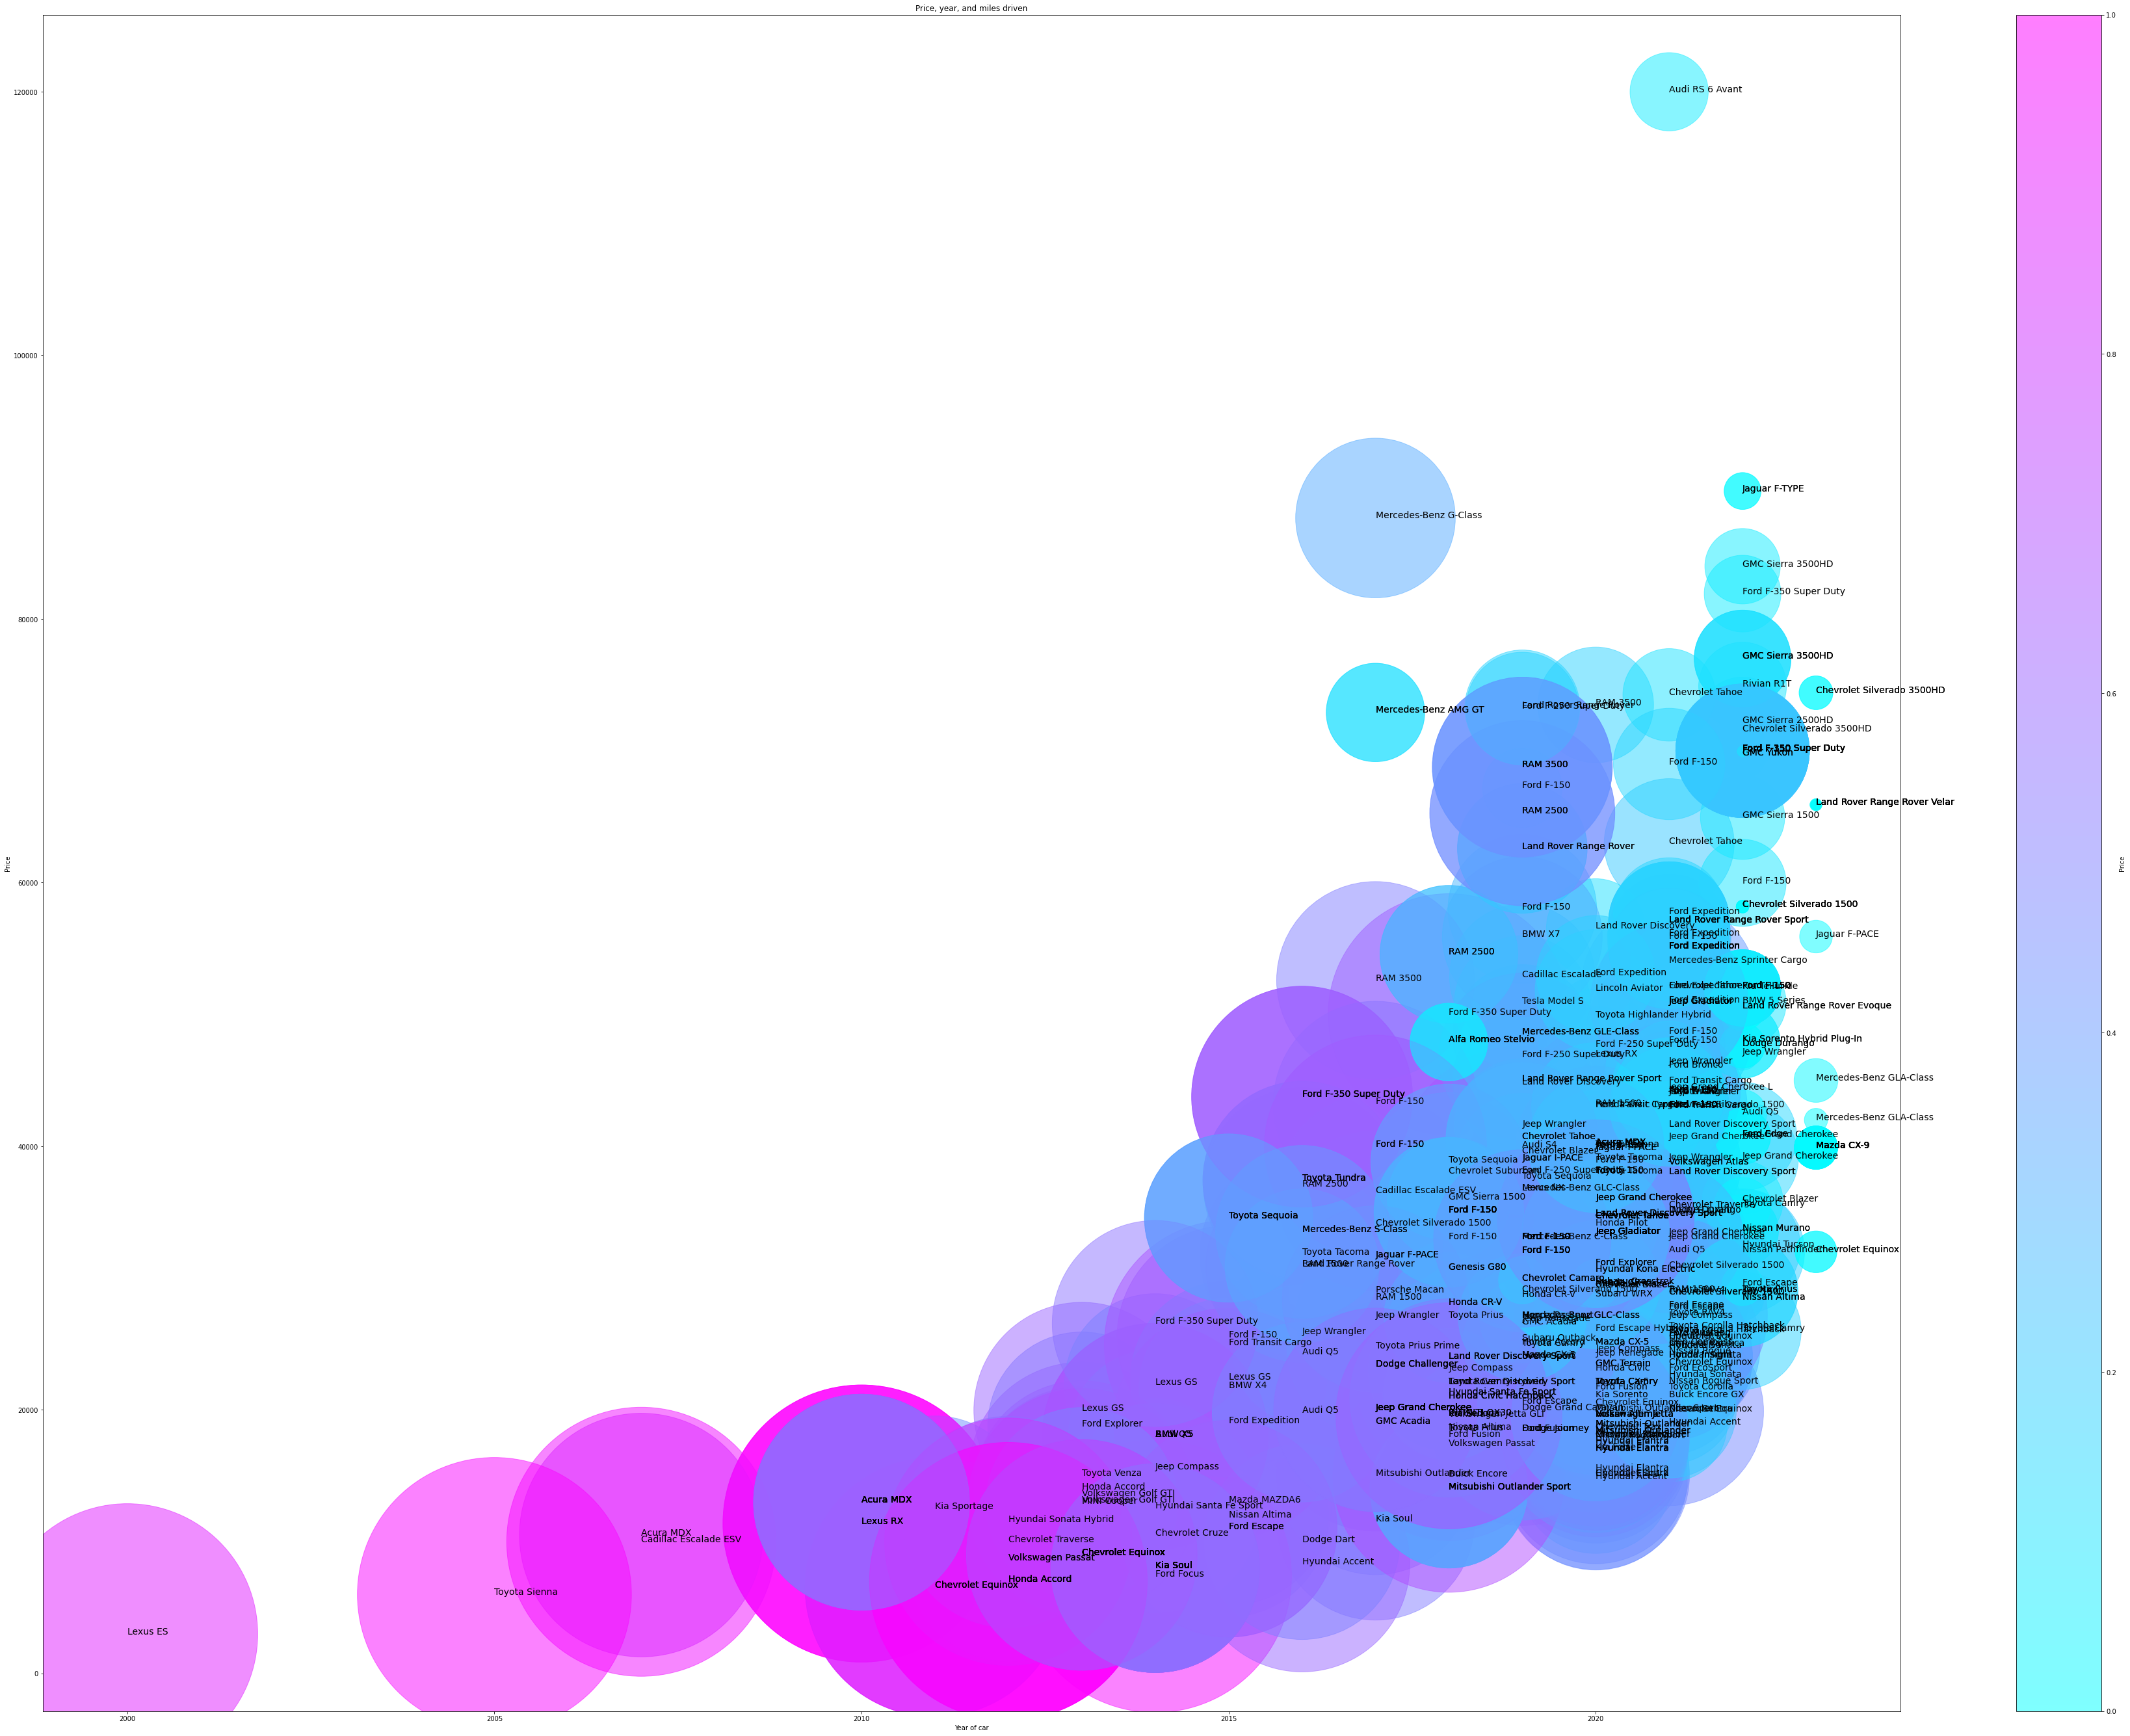

In [66]:

import matplotlib.pyplot as plt


# extract the x, y, and s values
x = df['carYear']
y = df['price']
s = df['mileage']

# normalize the size of bubbles between 0 and 1
s_norm = (s - s.min()) / (s.max() - s.min())

# create the scatter plot
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, s=s, alpha=0.5, c=s_norm, cmap='cool')

# add labels and title
ax.set_xlabel('Year of car')
ax.set_ylabel('Price')
ax.set_title('Price, year, and miles driven')

# add annotations for make and model names
for i, row in df.iterrows():
    ax.annotate(row['makeName'] + ' ' + row['modelName'], (x[i], y[i]), fontsize=14)

# set figure size to 8 times larger
fig.set_size_inches(64, 48)


# set the colorbar
cbar = plt.colorbar(scatter)
cbar.ax.set_ylabel('Price')

# show the plot
plt.show()

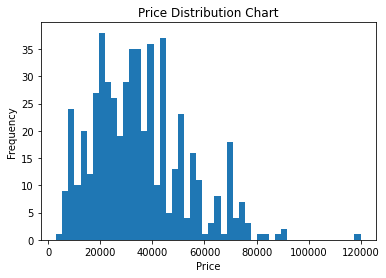

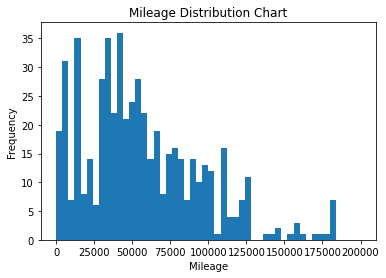

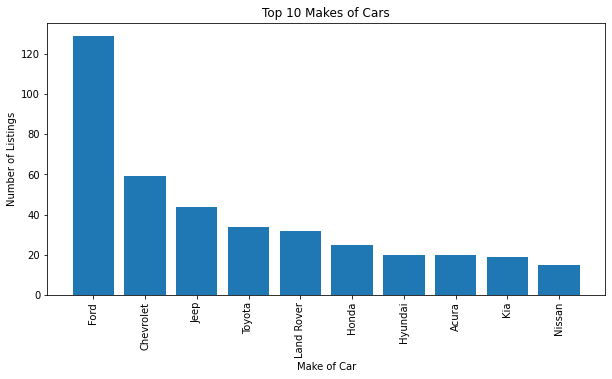

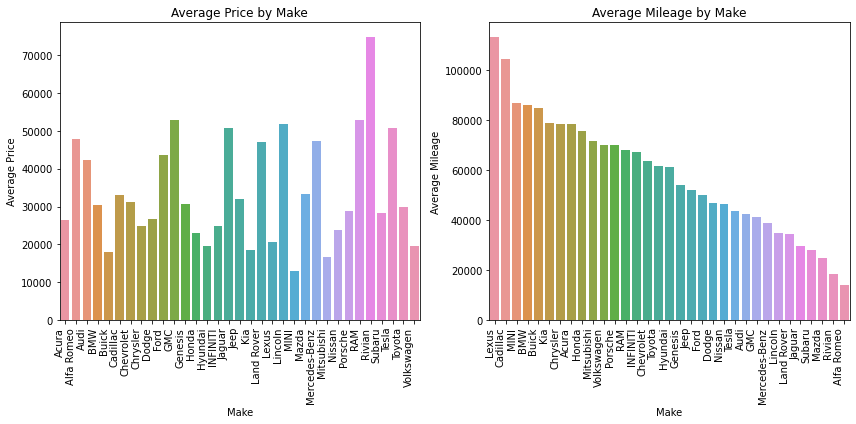

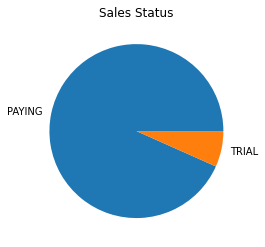

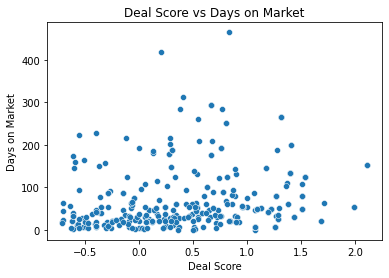

                            OLS Regression Results                            
Dep. Variable:           daysOnMarket   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     16.38
Date:                Tue, 02 May 2023   Prob (F-statistic):           6.24e-05
Time:                        19:27:41   Log-Likelihood:                -2283.6
No. Observations:                 402   AIC:                             4571.
Df Residuals:                     400   BIC:                             4579.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.2490      4.497     12.731      0.0

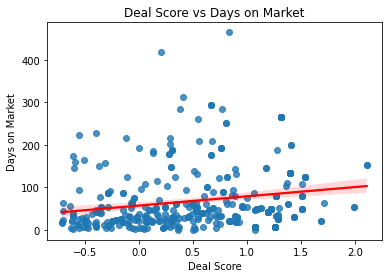

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# extract price column
prices = df['price']

# plot histogram of prices
plt.hist(prices, bins=50)
plt.title("Price Distribution Chart")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# Extract the mileage data
mileage = df['mileage']

# Plot a histogram of the mileage data
plt.hist(mileage, bins=50, range=(0, 200000))
plt.xlabel('Mileage')
plt.ylabel('Frequency')
plt.title('Mileage Distribution Chart')
plt.show()

# Count the number of listings for each make of car
makes_counts = df["makeName"].value_counts()

# Select only the top 10 makes
top_makes_counts = makes_counts.head(10)

# Plot the top 10 makes chart
plt.figure(figsize=(10,5))
plt.bar(top_makes_counts.index, top_makes_counts.values)
plt.title("Top 10 Makes of Cars")
plt.xlabel("Make of Car")
plt.ylabel("Number of Listings")
plt.xticks(rotation=90)
plt.show()

# Plot Avg Price by Make

# convert 'price' column to a numerical data type
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# group the DataFrame by make and calculate the average price and mileage for each make
avg_price = df.groupby('makeName')['price'].mean().reset_index()
avg_mileage = df.groupby('makeName')['mileage'].mean().sort_values(ascending=False)

# create two axes on the same figure
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# plot the average price on the first axis
sns.barplot(x='makeName', y='price', data=avg_price, ax=ax1)
ax1.set_xticklabels(avg_price['makeName'], rotation=90, ha='right')
ax1.set_xlabel('Make')
ax1.set_ylabel('Average Price')
ax1.set_title('Average Price by Make')

# plot the average mileage on the second axis
sns.barplot(x=avg_mileage.index, y=avg_mileage, ax=ax2)
ax2.set_xticklabels(avg_mileage.index, rotation=90, ha='right')
ax2.set_xlabel('Make')
ax2.set_ylabel('Average Mileage')
ax2.set_title('Average Mileage by Make')

# display the plots
plt.tight_layout()
plt.show()

# Sales Status Pie Chart

# extract the salesStatus column
sales_status = df["salesStatus"]

# count the number of occurrences of each sales status
sales_status_counts = sales_status.value_counts()

# plot the sales status counts as a pie chart
plt.pie(sales_status_counts, labels=sales_status_counts.index)
plt.title("Sales Status")
plt.show()

# Deal Score vs Days on Market Analysis
import statsmodels.api as sm

# Prepare the data
dfdrpna = df
dfdrpna = dfdrpna.dropna()  # remove rows with missing values
dfdrpna = dfdrpna[(dfdrpna['dealScore'] >= -3) & (dfdrpna['dealScore'] <= 3)]  # remove outliers

# Fit a linear regression model
X = dfdrpna['dealScore']
y = dfdrpna['daysOnMarket']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())


# Create a scatter plot with the regression line
sns.regplot(x='dealScore', y='daysOnMarket', data=dfdrpna, line_kws={'color': 'red'})

# Customize the plot
plt.title('Deal Score vs Days on Market')
plt.xlabel('Deal Score')
plt.ylabel('Days on Market')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()


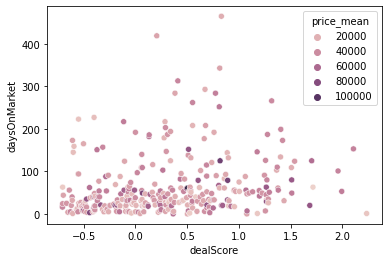

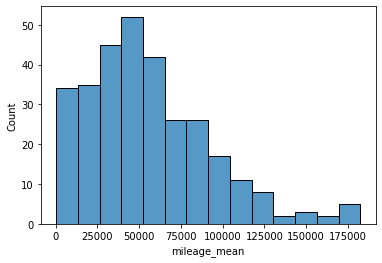

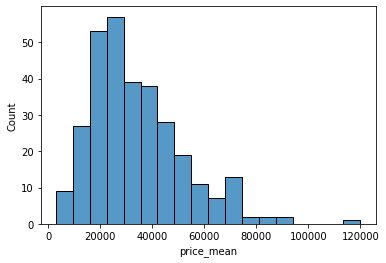

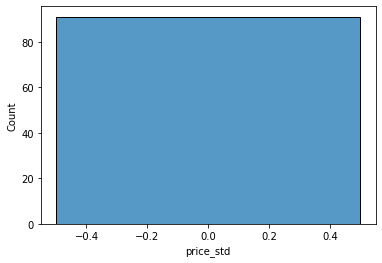

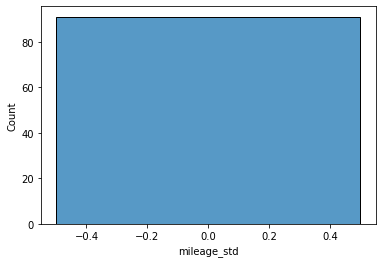

In [97]:

# Group the data by deal score and days on market
grouped_df = df.groupby(["dealScore", "daysOnMarket"])

# Compute the mean and standard deviation of the relevant features for each group
agg_df = grouped_df.agg({"makeName": "first", 
                         "modelName": "first", 
                         "bodyTypeGroupId": "first", 
                         "mileage": ["mean", "std"], 
                         "price": ["mean", "std"]})

# Flatten the column names
agg_df.columns = ["_".join(col) for col in agg_df.columns.values]

# Reset the index to make the groupings columns again
agg_df.reset_index(inplace=True)

# Create a scatterplot of deal score vs days on market
sns.scatterplot(data=agg_df, x="dealScore", y="daysOnMarket", hue="price_mean")
plt.show()

# Create a histogram of the mileage means
sns.histplot(data=agg_df, x="mileage_mean")
plt.show()

# Create a histogram of the price means
sns.histplot(data=agg_df, x="price_mean")
plt.show()

# Create a histogram of the price standard deviations
sns.histplot(data=agg_df, x="price_std")
plt.show()

# Create a histogram of the mileage standard deviations
sns.histplot(data=agg_df, x="mileage_std")
plt.show()


In [104]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the target variable
target = 'dealScore'

# Define the categorical variables to be encoded
#cat_vars = ['inclusionType', 'makeName', 'modelName', 'bodyTypeGroupId', 'driveTrain']
cat_vars = tuple(dfm.select_dtypes(include=['object']).columns.tolist())

# Define the numerical variables to be scaled
num_vars = ['mileage', 'carYear', 'daysOnMarket']

dfm = df
# Preprocess the data
#dfm = dfm.drop(['index', 'id', 'listingTitle', 'staticLoadListingTitle', 'table_name'], axis=1)
# Drop the numeric columns
numeric_cols = dfm.select_dtypes(include=np.number).columns.tolist()
dfm = dfm.drop(numeric_cols, axis=1)

dfm = pd.get_dummies(dfm, columns=cat_vars)
#dfm = dfm.fillna(df.mean())
dfm = dfm.apply(lambda x: x.fillna(x.mean()) if x.dtype != "object" else x)

scaler = StandardScaler()
dfm[num_vars] = scaler.fit_transform(dfm[num_vars])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(target, axis=1), dfm[target], test_size=0.2, random_state=42)

# Train the machine learning model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the performance of the machine learning model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.3f}')
print(f'Mean Squared Error: {mse:.3f}')
print(f'R-squared: {r2:.3f}')

# Identify the primary variables that explain high dealer scores and short time on market
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
top_feats = feat_importances.nlargest(10)
print(top_feats)


KeyError: ('makeId', 'modelId', 'trimName', 'bodyTypeName', 'salesStatus', 'options', 'mileageString', 'unitMileage', 'exteriorColorName', 'normalizedExteriorColor', 'priceString', 'expectedPriceString', 'priceDifferentialString', 'dealRating', 'isFeatured', 'featuredTypes', 'mainPictureUrl', 'originalPictureUrl', 'originalPictureData', 'mainPictureData', 'sellerType', 'sellerCity', 'sellerRegion', 'sellerPostalCode', 'serviceProviderName', 'phoneNumber', 'phoneNumberString', 'localizedExteriorColor', 'howToShop', 'structuredDataDealerLogoUrl', 'structuredDataDealerName', 'financeDto', 'ncapOverallSafetyRating', 'vin', 'stockNumber', 'entityTitle', 'reportDate', 'localizedDriveTrain', 'cityFuelEconomy', 'highwayFuelEconomy', 'combinedFuelEconomy', 'localizedFuelEconomy', 'localizedFuelType', 'localizedCombinedFuelEconomy', 'localizedDoors', 'localizedEngineDisplayName')

In [106]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

dfm = df
# Define the target variable
target = 'dealScore'

# Define the categorical variables to be encoded
cat_vars = tuple(dfm.select_dtypes(include=['object']).columns.tolist())

# Define the numerical variables to be scaled
num_vars = ['mileage', 'carYear', 'daysOnMarket']

# Preprocess the data
dfm = df.drop(num_vars, axis=1)
dfm = pd.get_dummies(dfm, columns=cat_vars)
dfm = dfm.apply(lambda x: x.fillna(x.mean()) if x.dtype != "object" else x)

scaler = StandardScaler()
dfm[num_vars] = scaler.fit_transform(df[num_vars])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(target, axis=1), dfm[target], test_size=0.2, random_state=42)

# Train the machine learning model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the performance of the machine learning model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.3f}')
print(f'Mean Squared Error: {mse:.3f}')
print(f'R-squared: {r2:.3f}')

# Identify the primary variables that explain high dealer scores and short time on market
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
top_feats = feat_importances.nlargest(10)
print(top_feats)


KeyError: ('makeId', 'modelId', 'trimName', 'bodyTypeName', 'salesStatus', 'options', 'mileageString', 'unitMileage', 'exteriorColorName', 'normalizedExteriorColor', 'priceString', 'expectedPriceString', 'priceDifferentialString', 'dealRating', 'isFeatured', 'featuredTypes', 'mainPictureUrl', 'originalPictureUrl', 'originalPictureData', 'mainPictureData', 'sellerType', 'sellerCity', 'sellerRegion', 'sellerPostalCode', 'serviceProviderName', 'phoneNumber', 'phoneNumberString', 'localizedExteriorColor', 'howToShop', 'structuredDataDealerLogoUrl', 'structuredDataDealerName', 'financeDto', 'ncapOverallSafetyRating', 'vin', 'stockNumber', 'entityTitle', 'reportDate', 'localizedDriveTrain', 'cityFuelEconomy', 'highwayFuelEconomy', 'combinedFuelEconomy', 'localizedFuelEconomy', 'localizedFuelType', 'localizedCombinedFuelEconomy', 'localizedDoors', 'localizedEngineDisplayName')